In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from examples.SMO.turbo import train_turbo, get_initial_points, TurboState
from uncertaintylearning.utils.networks import create_optimizer, create_network
import torch
import os
from botorch.test_functions import Ackley
from botorch.utils.transforms import unnormalize
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [3]:
features = 'xv'
dim = 10
batch_size = 1
n_init = 20
use_log_unc = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float
SMOKE_TEST = os.environ.get("SMOKE_TEST")
low, up = -10, 15


### Budget-constrained optimization for different Ackley functions

In [27]:
def transform_results(res):
    return np.maximum.accumulate(res, 1)

def plot_all(seed, dims):
    fig, axes = plt.subplots(1, len(dims), figsize=(20, 6))
    for d, dim in enumerate(dims):
        for k, v in {'gp': gp_results[dim][:1 + seed, :],
                    'turbo_gp': turbo_gp_results[dim][:1 + seed, :],
                    'deup_v': deup_v_results[dim][:1 + seed, :],
                    'turbo_deup_v': turbo_deup_v_results[dim][:1 + seed, :],
    #                 'deup_xv': deup_xv_results[:1 + seed, :],
    #                 'turbo_deup_xv': turbo_deup_xv_results[:1 + seed, :]
                    }.items():
            axes[d].errorbar(range(v.shape[1]), np.mean(v, axis=0), np.std(v, axis=0), label=k)
        axes[d].legend()
    plt.show()

seed 0 , gp current max -3.434401512145996


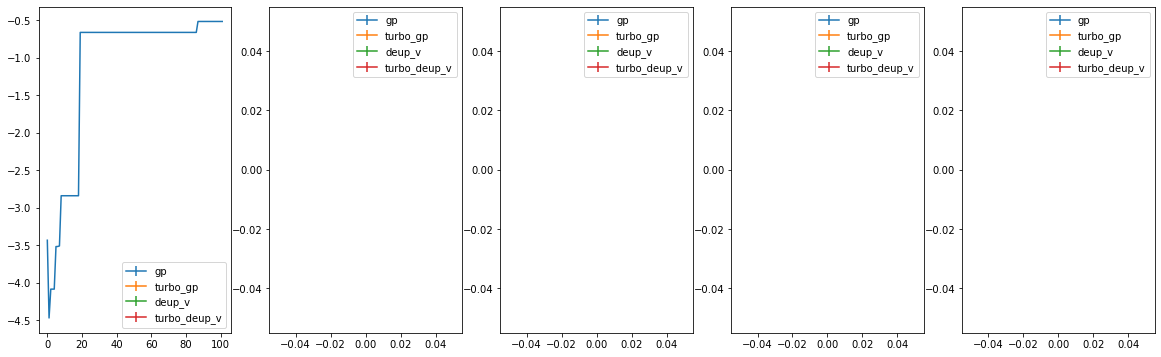

seed 0 , deup-v current max -3.434401512145996


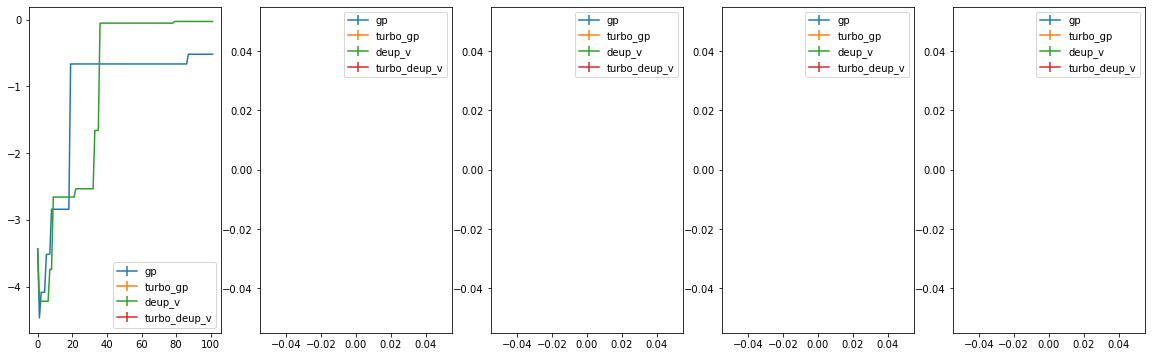

seed 0 , turbo gp current max -3.434401512145996


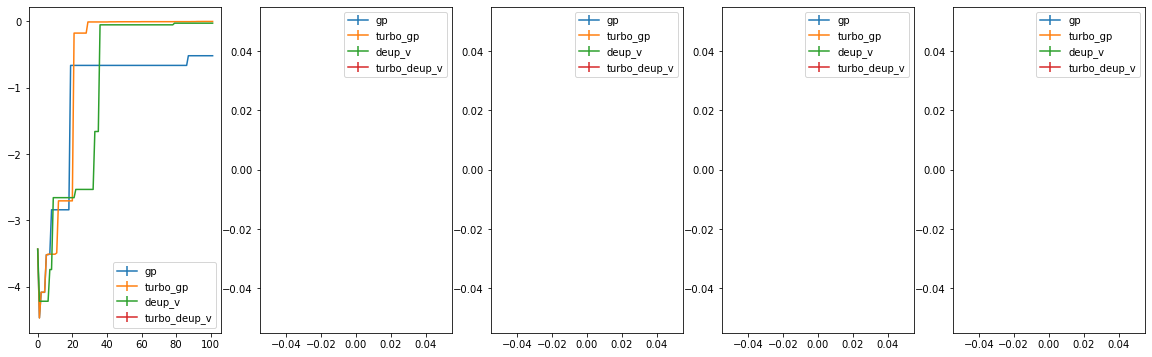

seed 0 , turbo-deup-v current max -3.434401512145996


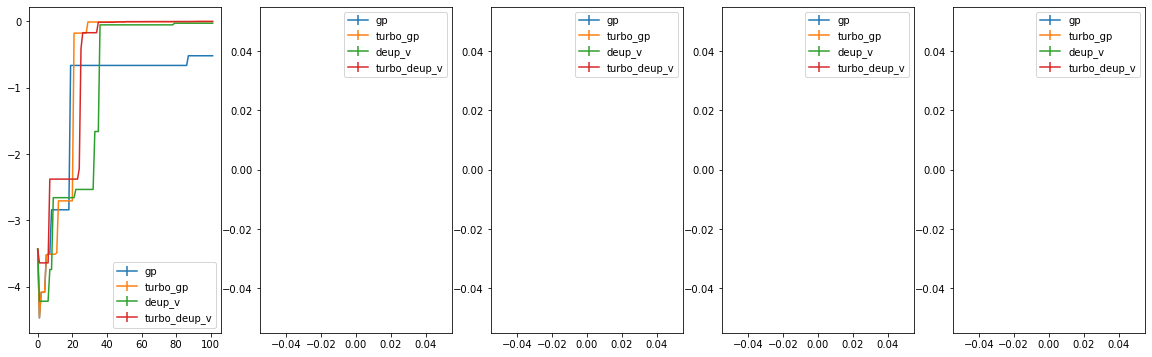

seed 1 , gp current max -6.265212059020996


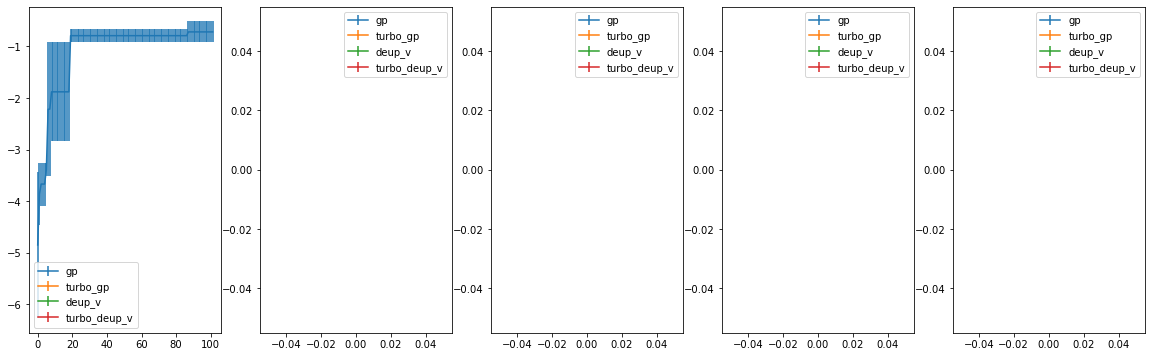

seed 1 , deup-v current max -6.265212059020996


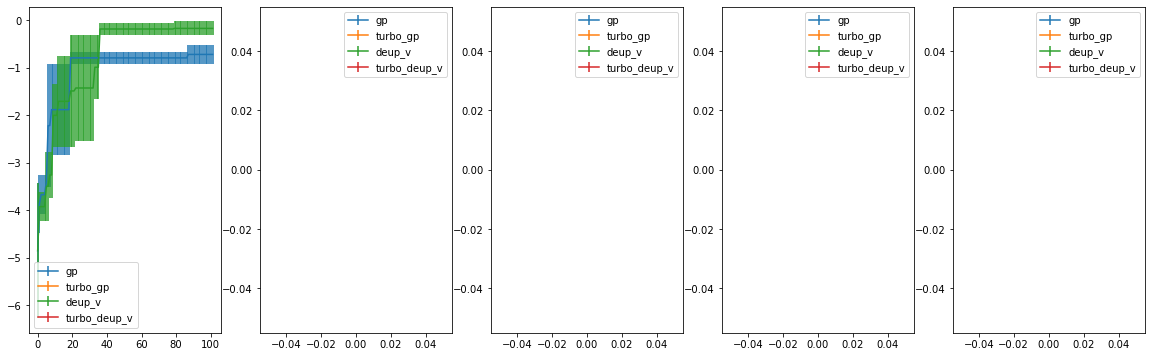

seed 1 , turbo gp current max -6.265212059020996


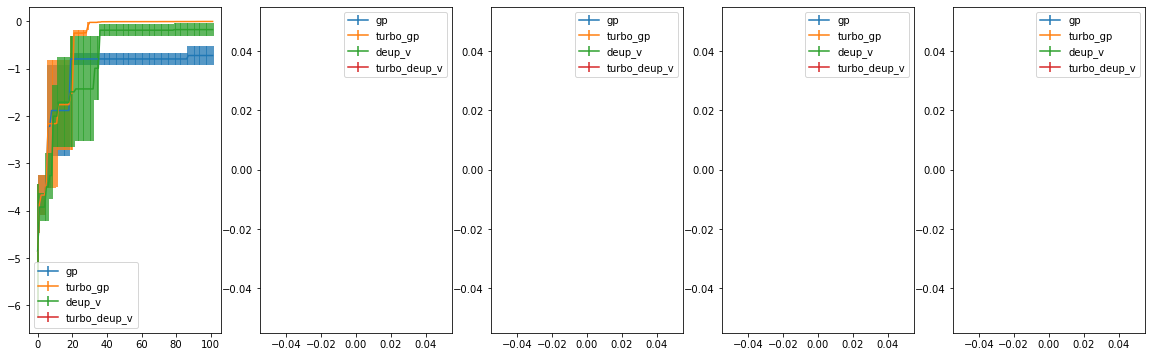

seed 1 , turbo-deup-v current max -6.265212059020996


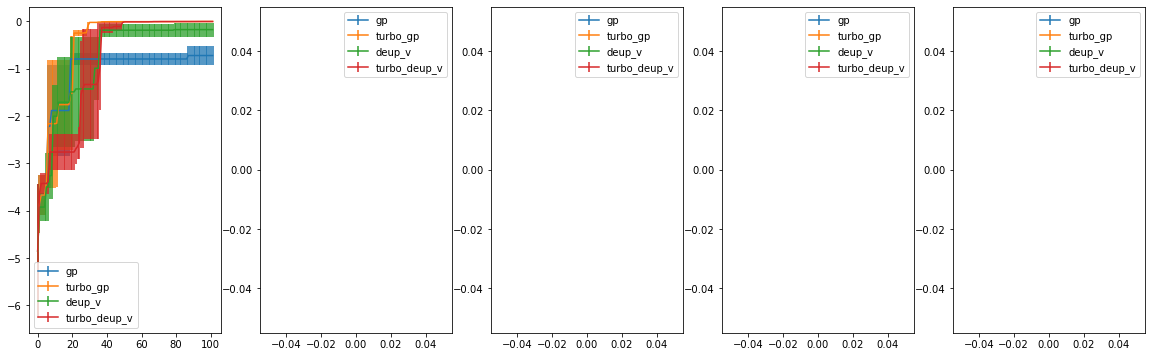

seed 2 , gp current max -6.024493217468262


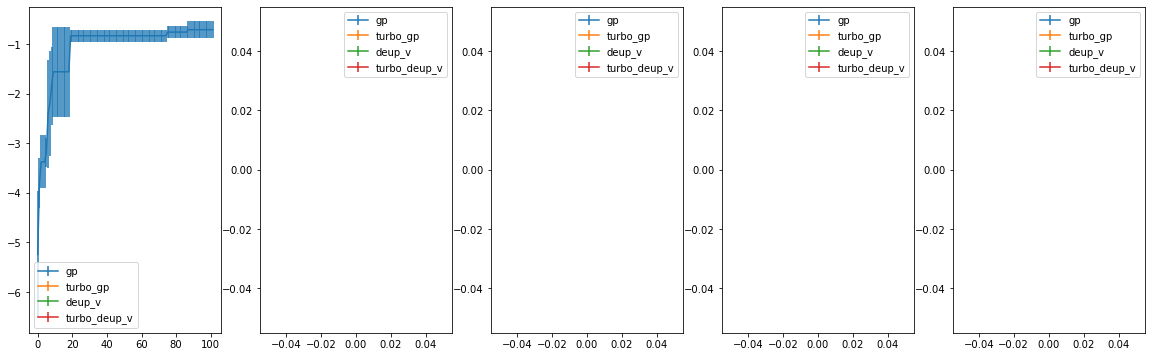

seed 2 , deup-v current max -6.024493217468262


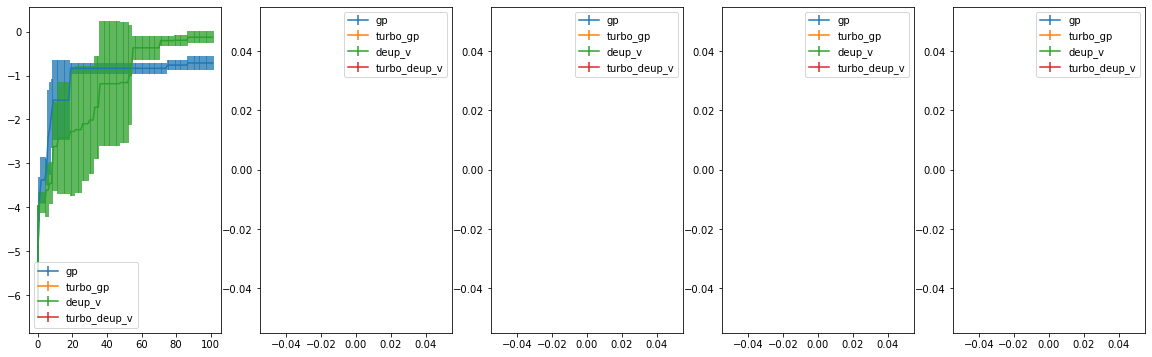

seed 2 , turbo gp current max -6.024493217468262


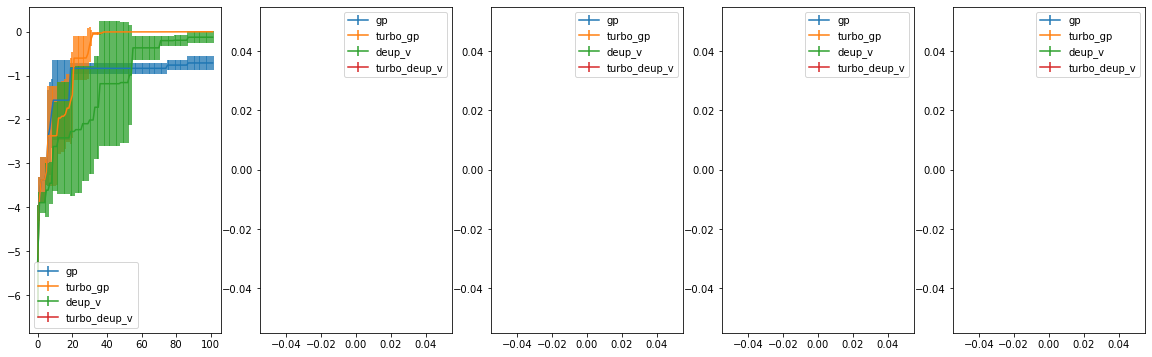

seed 2 , turbo-deup-v current max -6.024493217468262


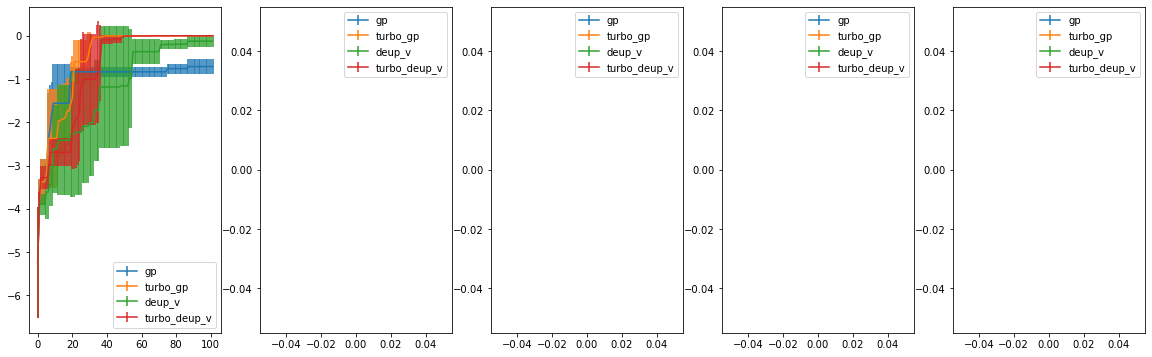

seed 0 , gp current max -11.816824913024902


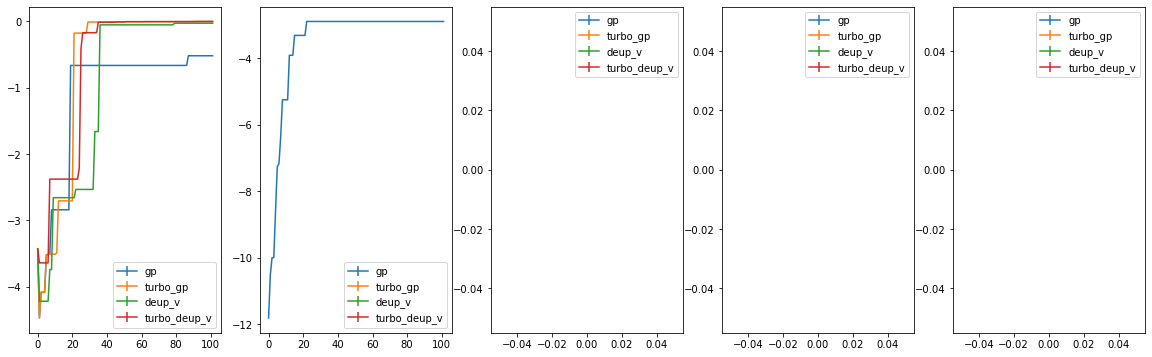

seed 0 , deup-v current max -11.816824913024902


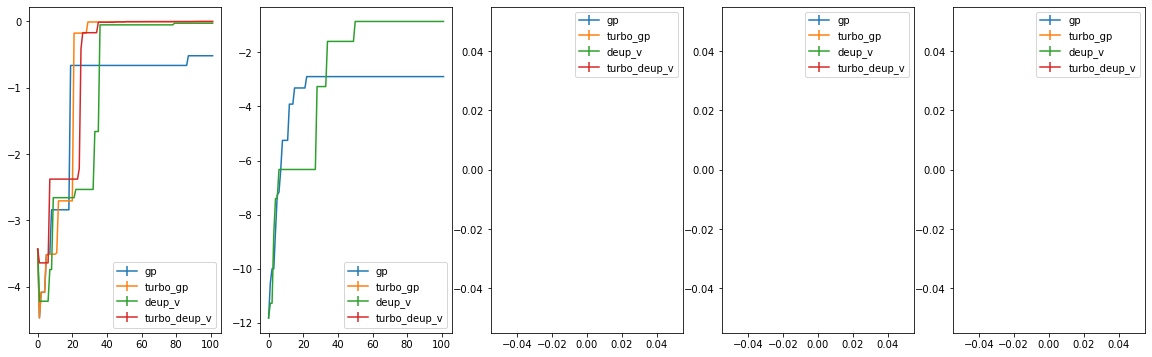

seed 0 , turbo gp current max -11.816824913024902


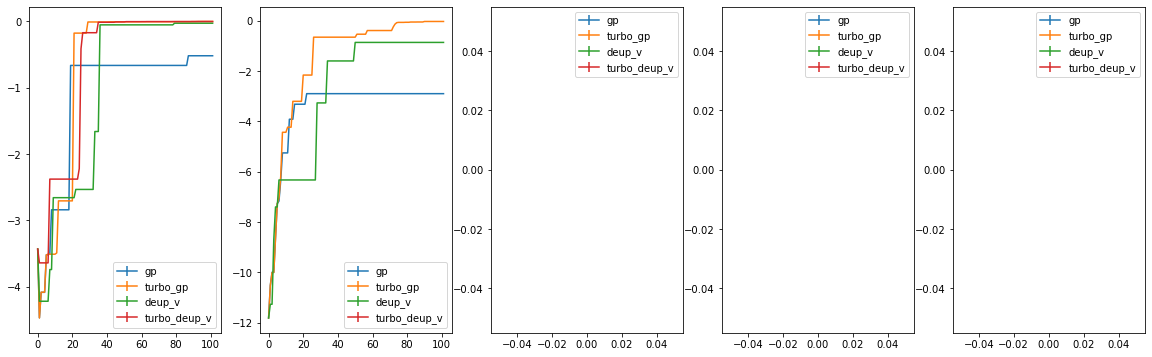

seed 0 , turbo-deup-v current max -11.816824913024902


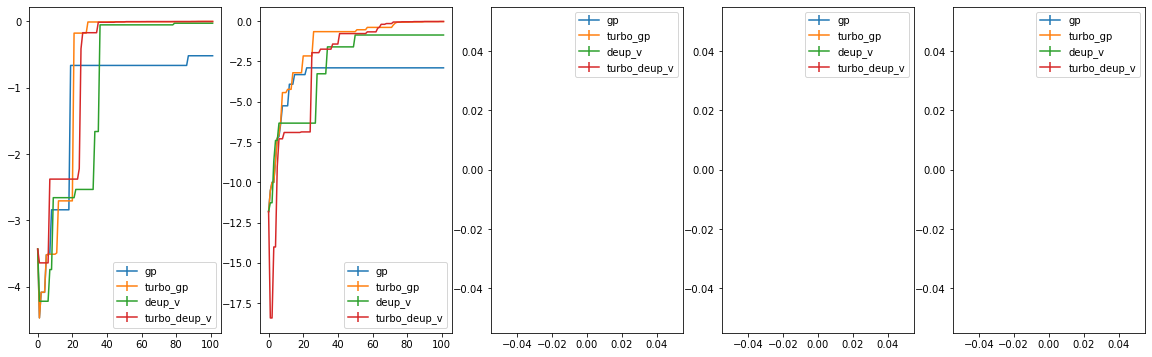

seed 1 , gp current max -11.009882926940918


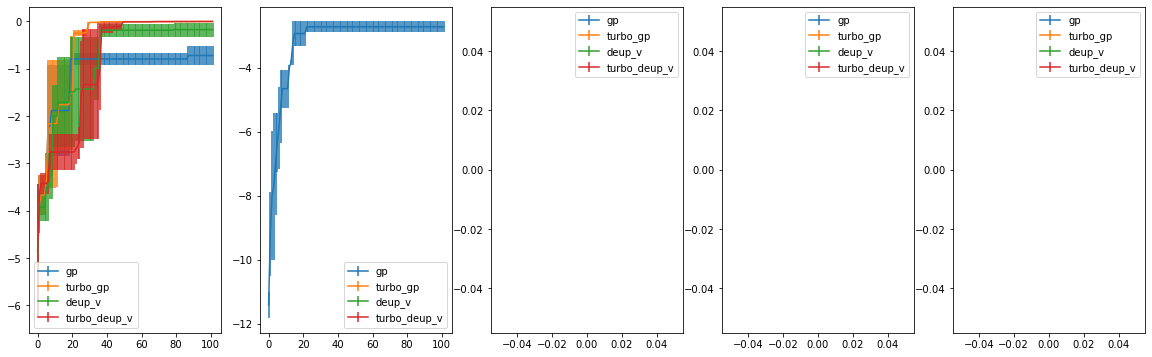

seed 1 , deup-v current max -11.009882926940918


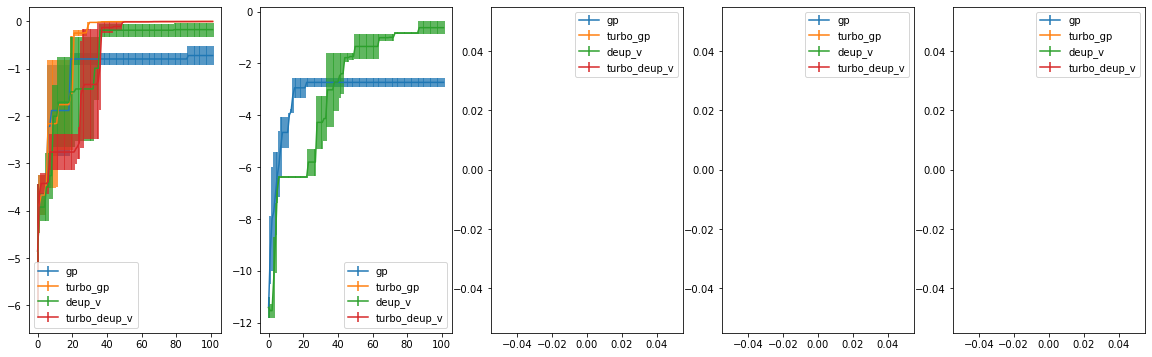

seed 1 , turbo gp current max -11.009882926940918


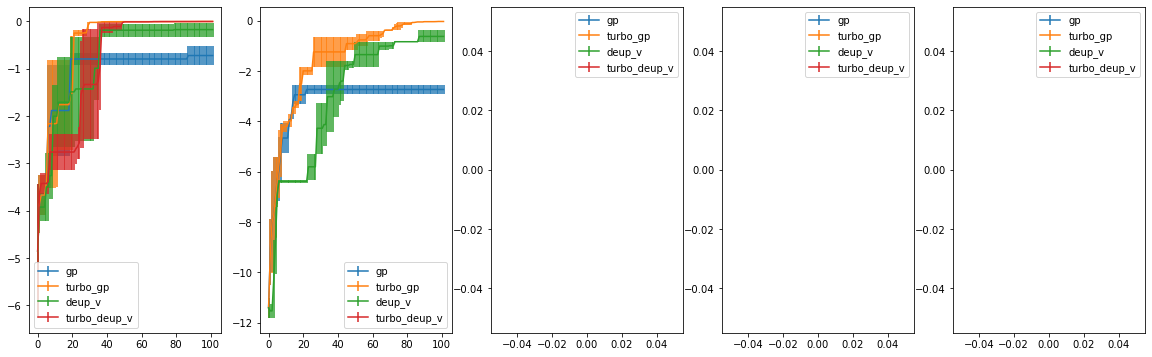

seed 1 , turbo-deup-v current max -11.009882926940918


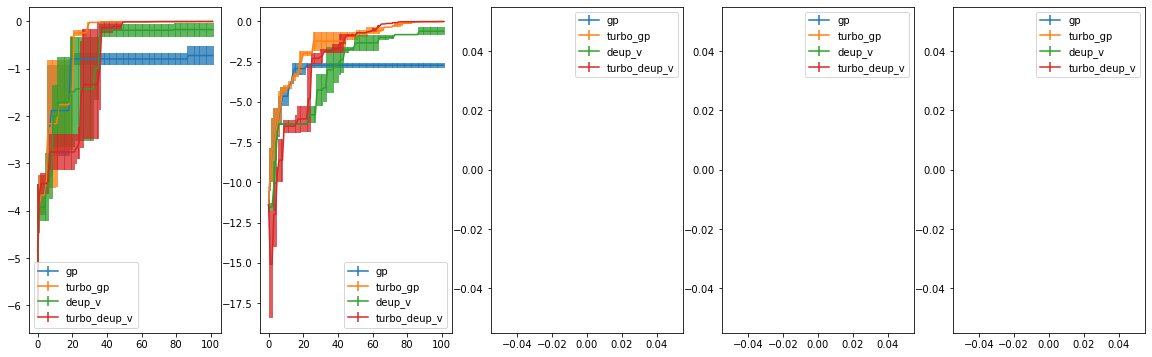

seed 2 , gp current max -11.418397903442383


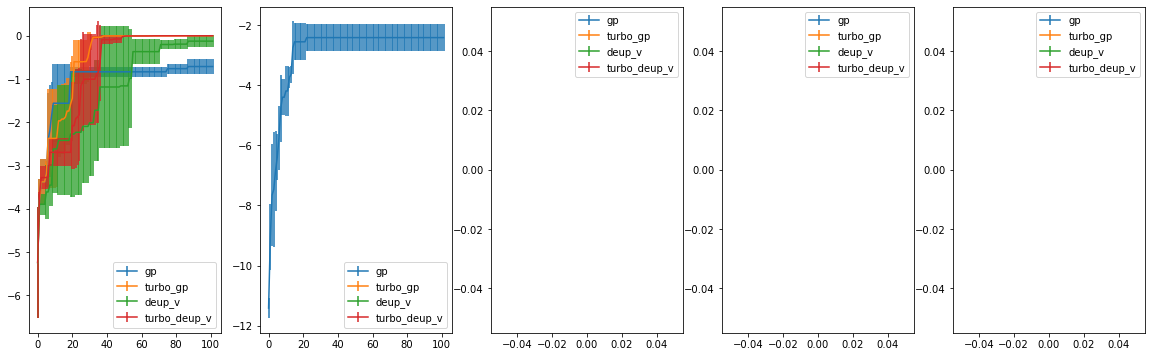

seed 2 , deup-v current max -11.418397903442383


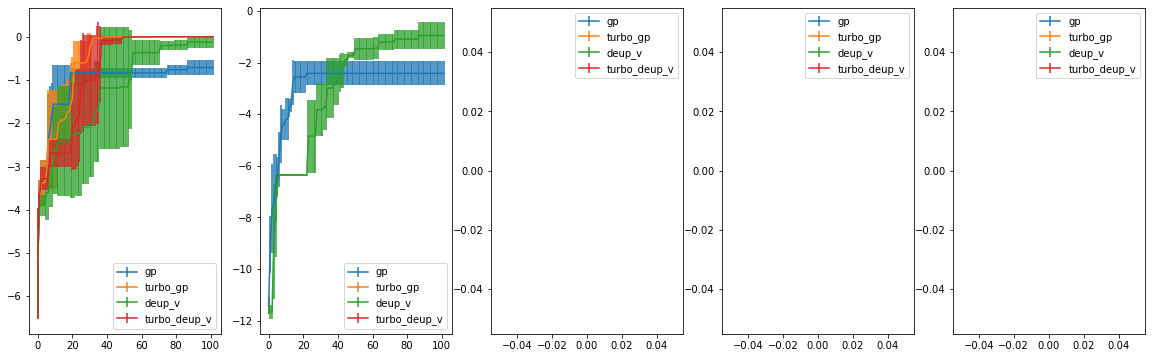

seed 2 , turbo gp current max -11.418397903442383


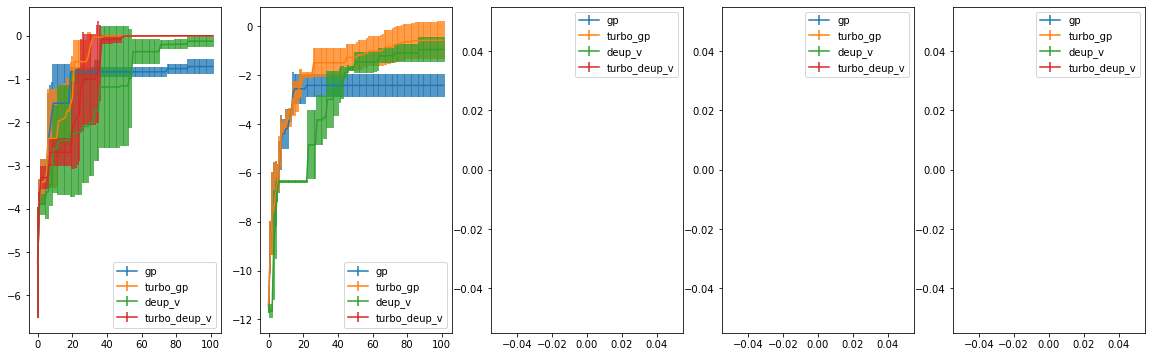

seed 2 , turbo-deup-v current max -11.418397903442383


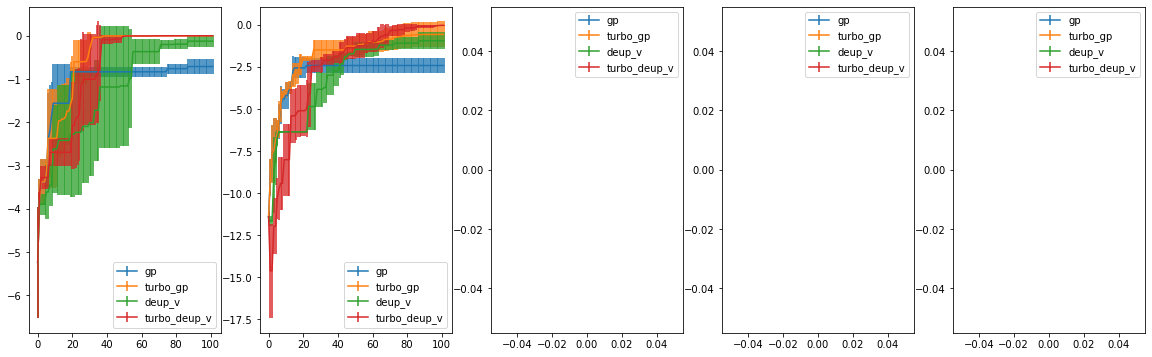

seed 0 , gp current max -15.115740776062012


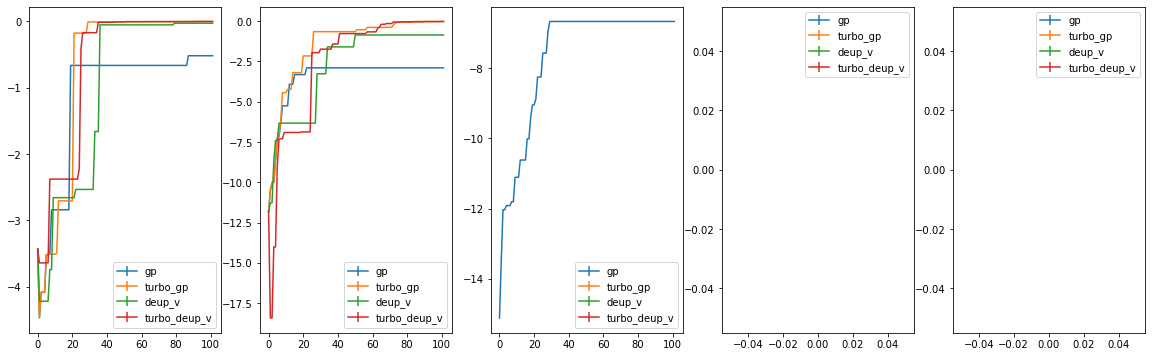

seed 0 , deup-v current max -15.115740776062012


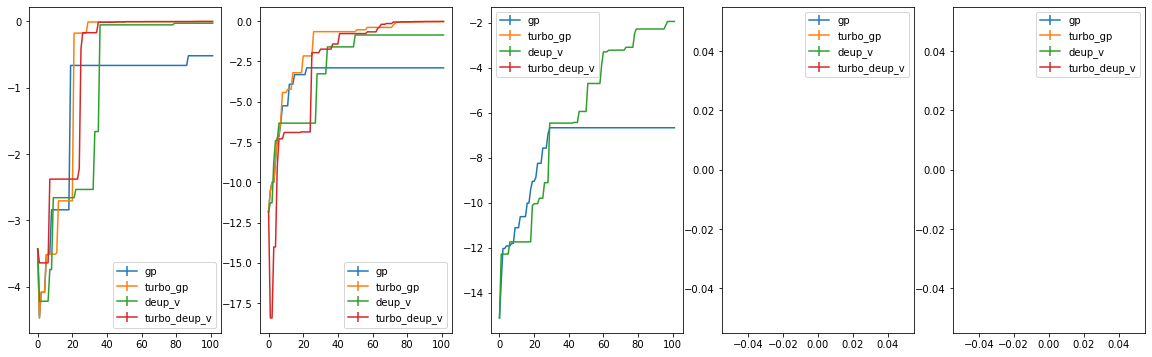

seed 0 , turbo gp current max -15.115740776062012


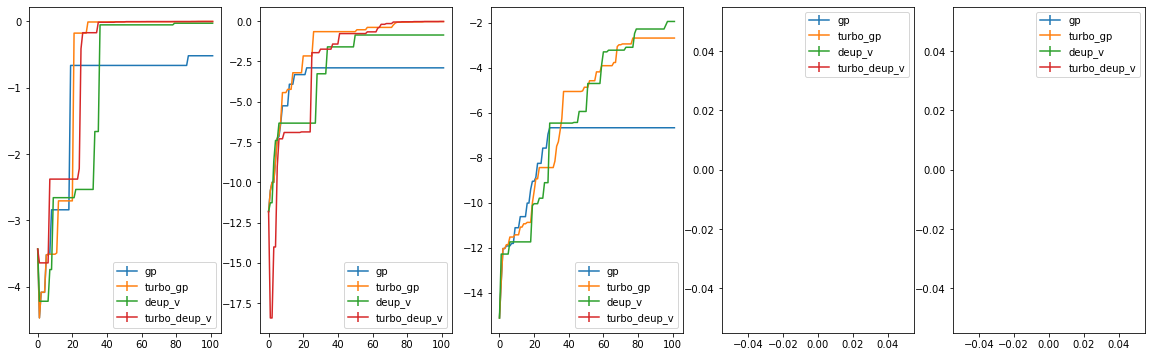

seed 0 , turbo-deup-v current max -15.115740776062012


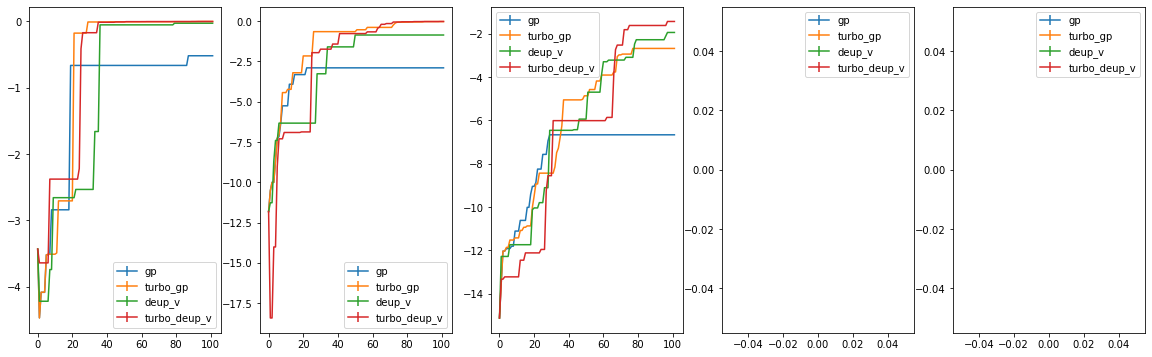

seed 1 , gp current max -14.425365447998047


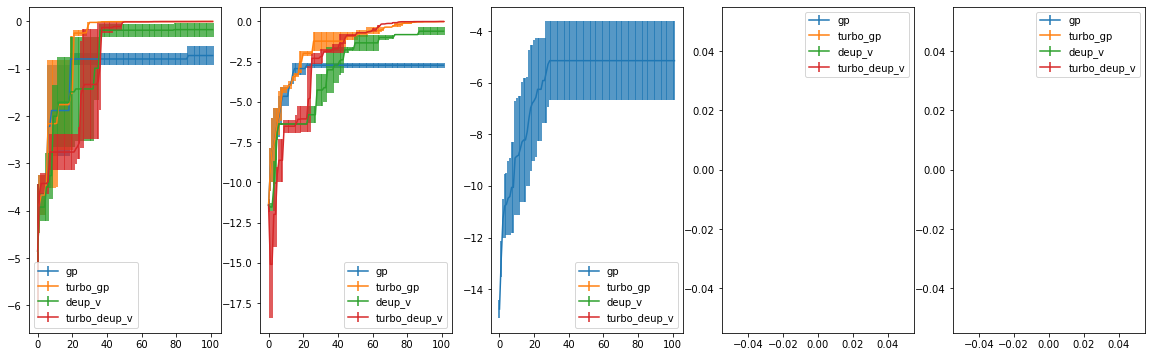

seed 1 , deup-v current max -14.425365447998047


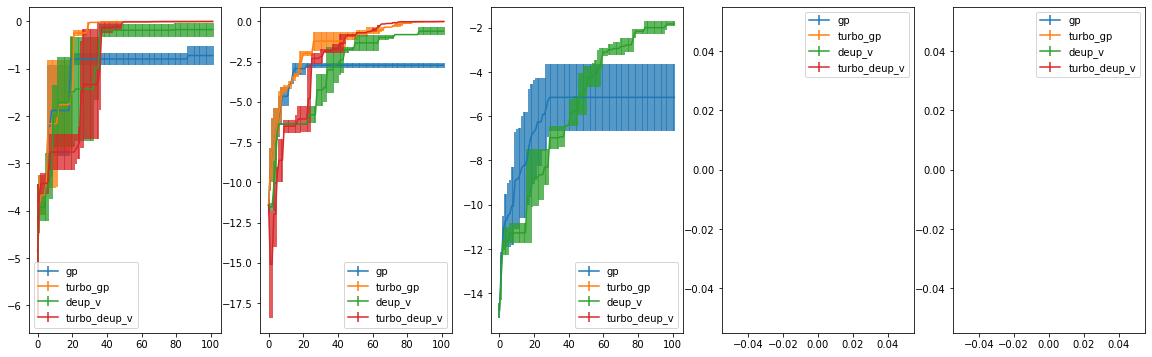

seed 1 , turbo gp current max -14.425365447998047


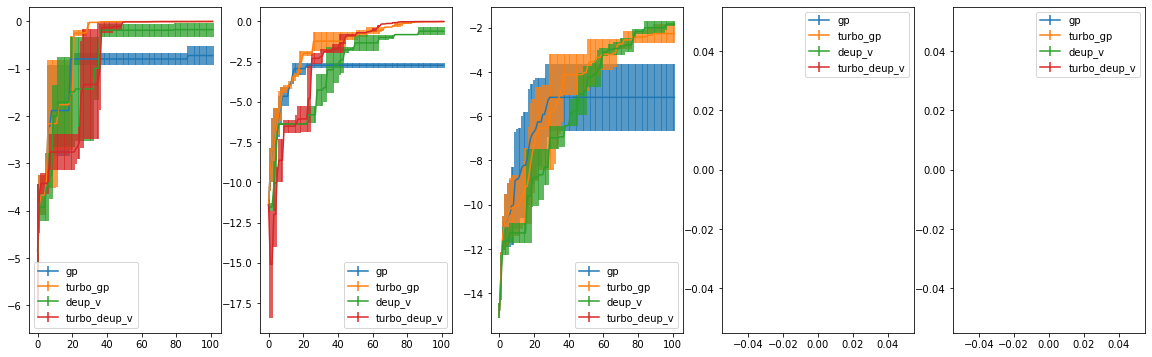

seed 1 , turbo-deup-v current max -14.425365447998047


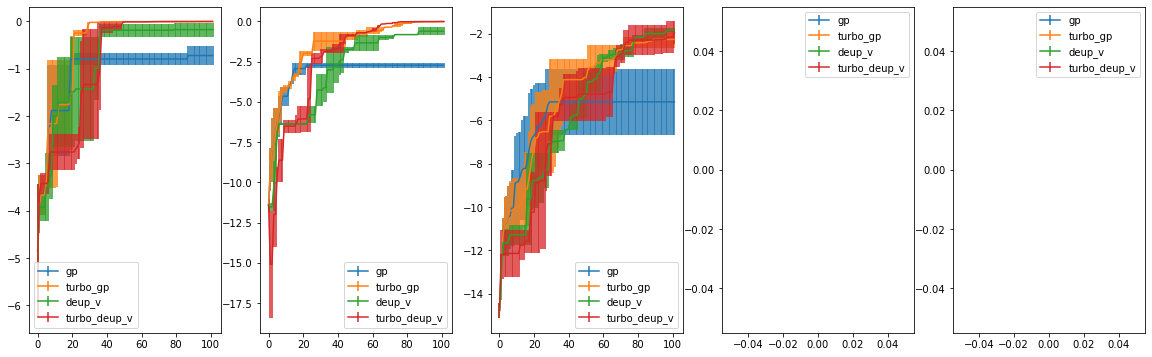

seed 2 , gp current max -12.942035675048828


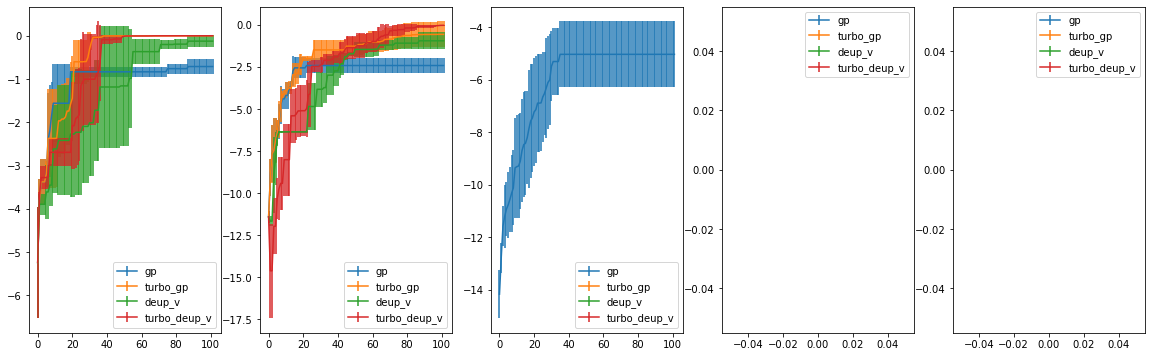

seed 2 , deup-v current max -12.942035675048828


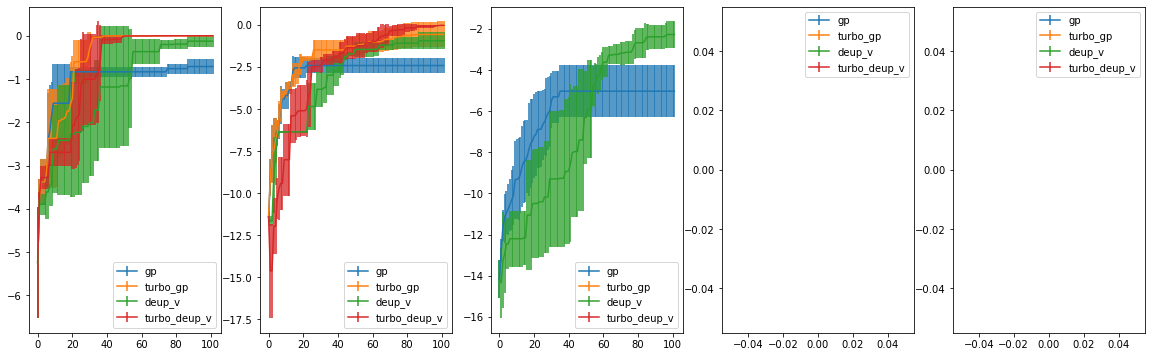

seed 2 , turbo gp current max -12.942035675048828


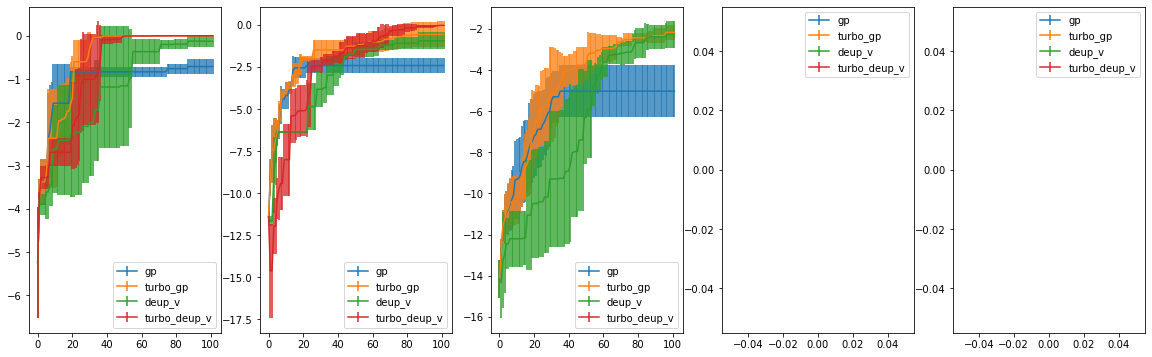

seed 2 , turbo-deup-v current max -12.942035675048828


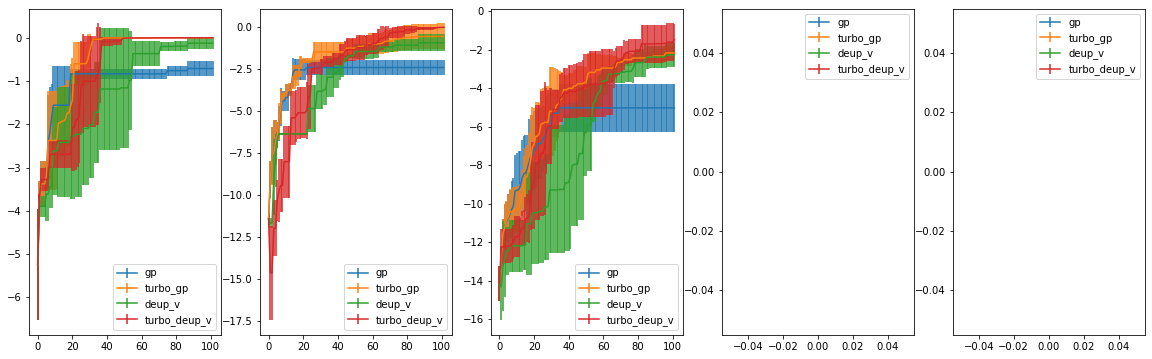

seed 0 , gp current max -16.372867584228516


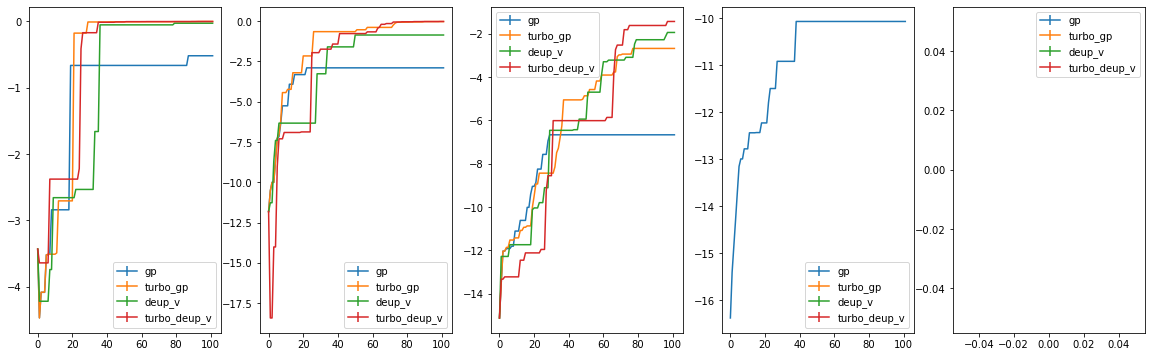

seed 0 , deup-v current max -16.372867584228516


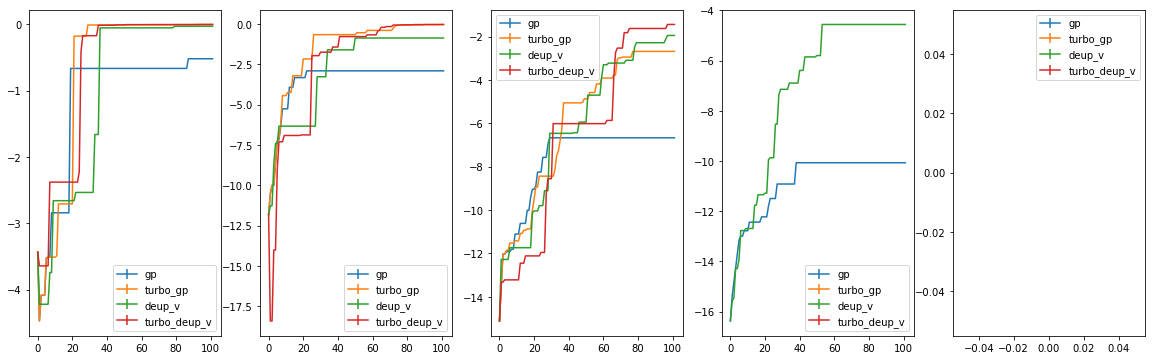

seed 0 , turbo gp current max -16.372867584228516


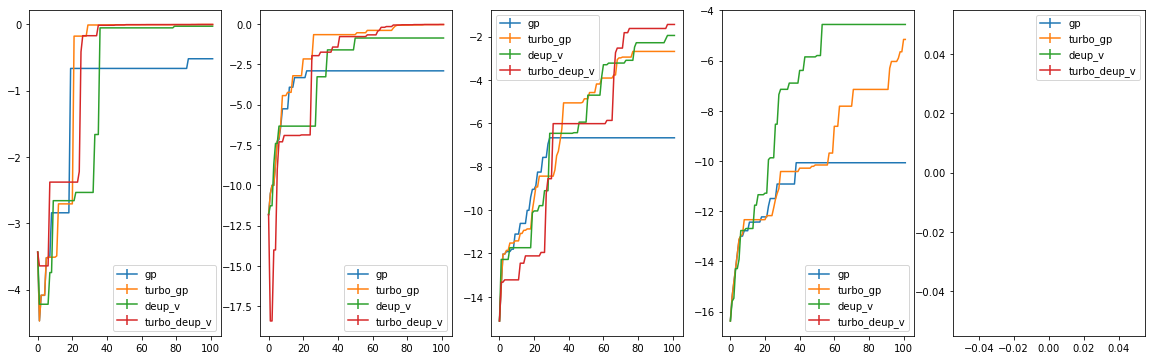

seed 0 , turbo-deup-v current max -16.372867584228516


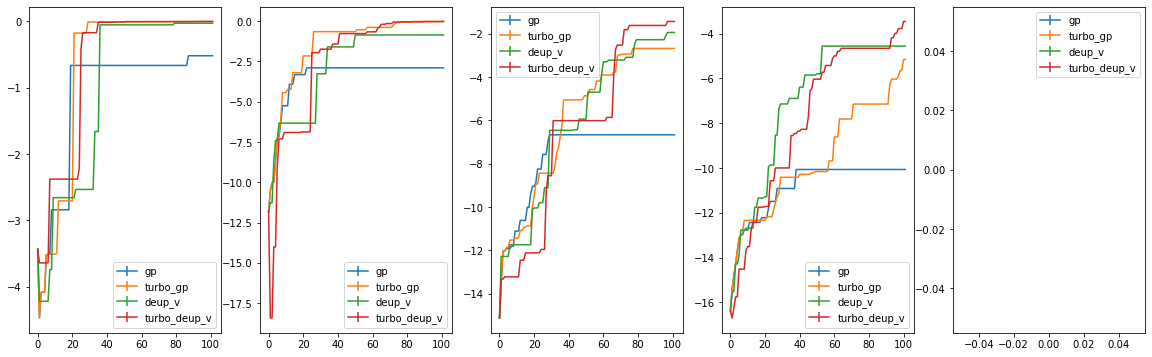

seed 1 , gp current max -16.022716522216797


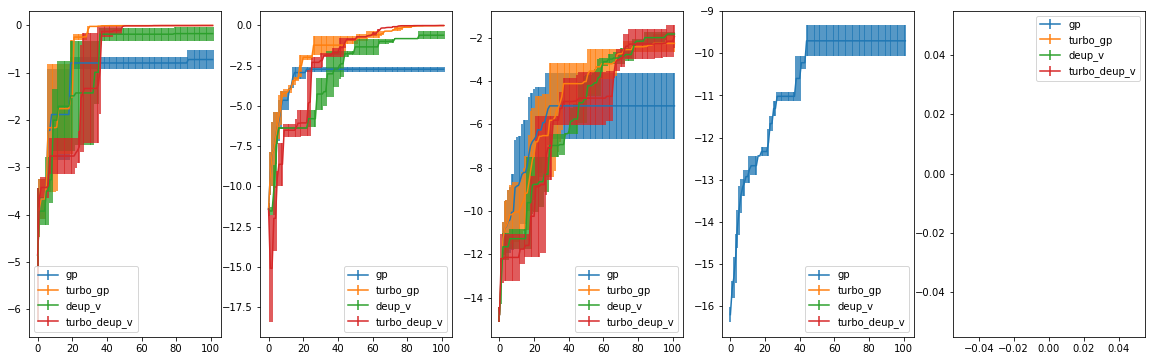

seed 1 , deup-v current max -16.022716522216797


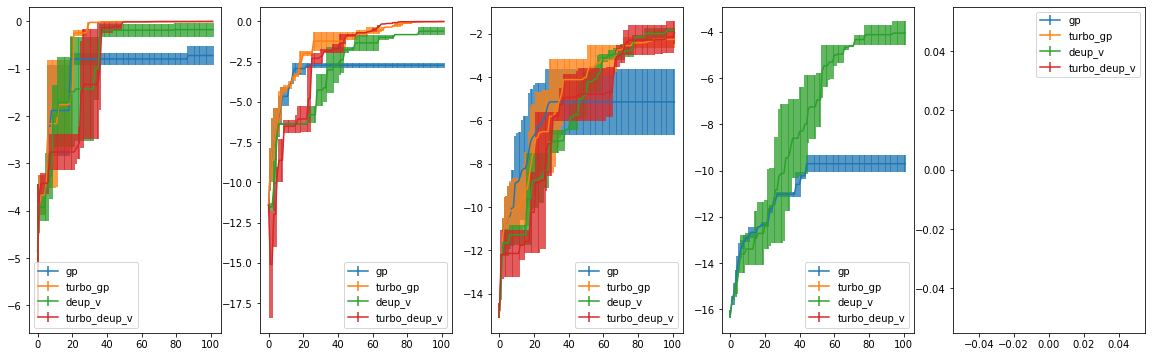

seed 1 , turbo gp current max -16.022716522216797


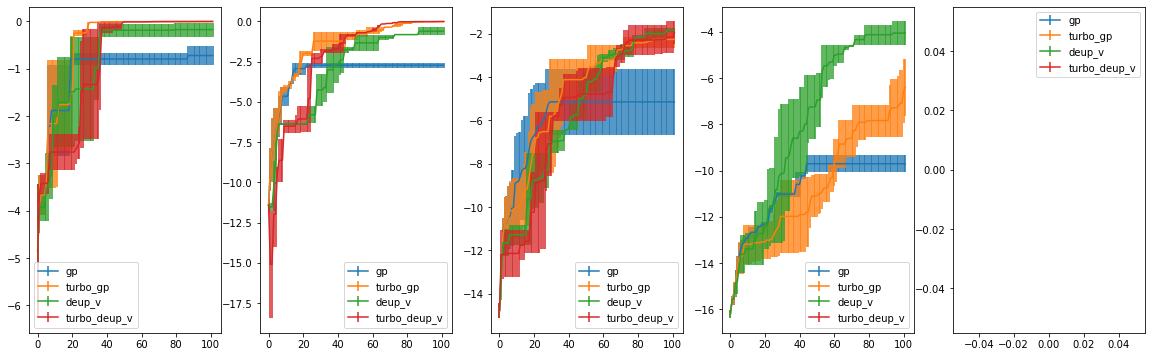

seed 1 , turbo-deup-v current max -16.022716522216797


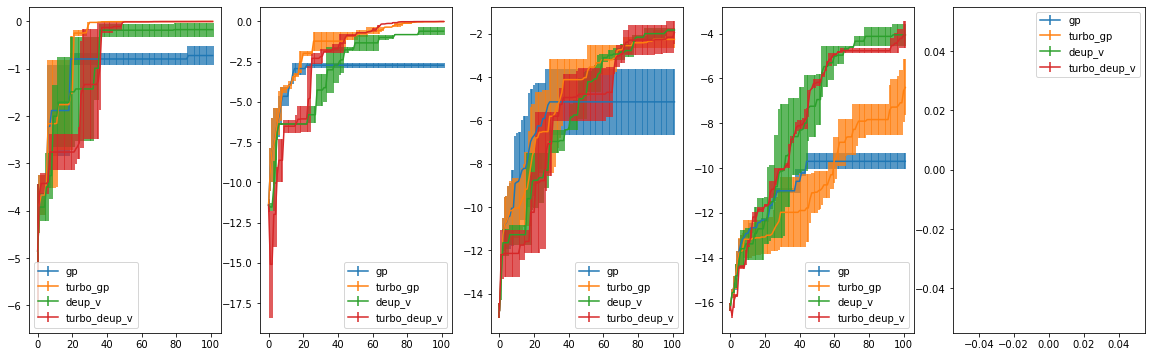

seed 2 , gp current max -15.56639575958252


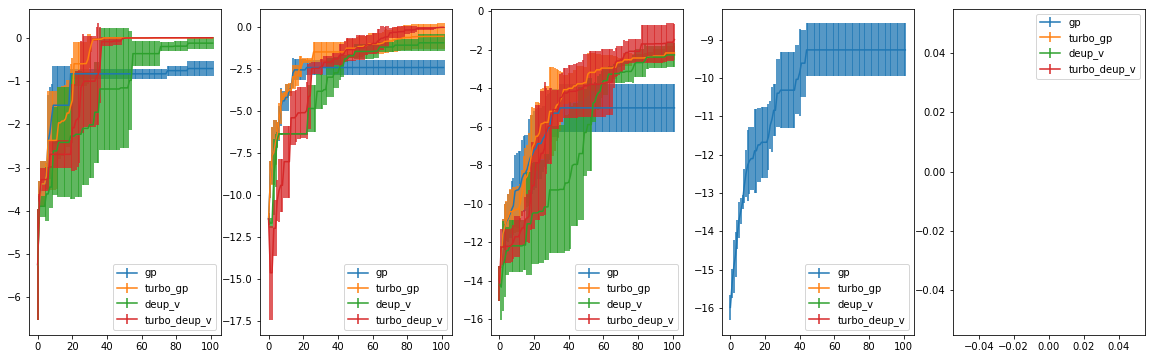

seed 2 , deup-v current max -15.56639575958252


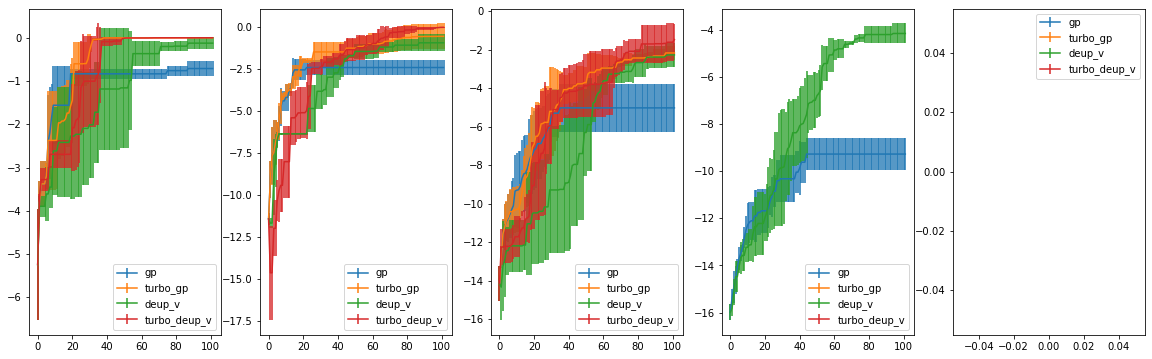

seed 2 , turbo gp current max -15.56639575958252


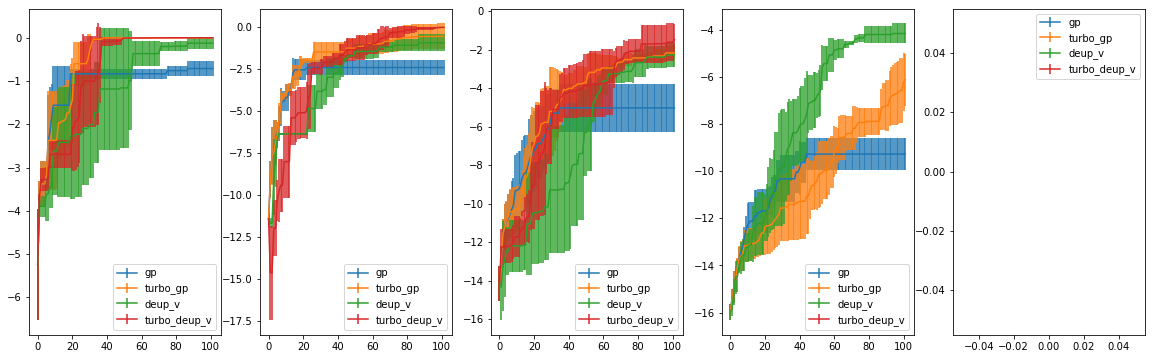

seed 2 , turbo-deup-v current max -15.56639575958252


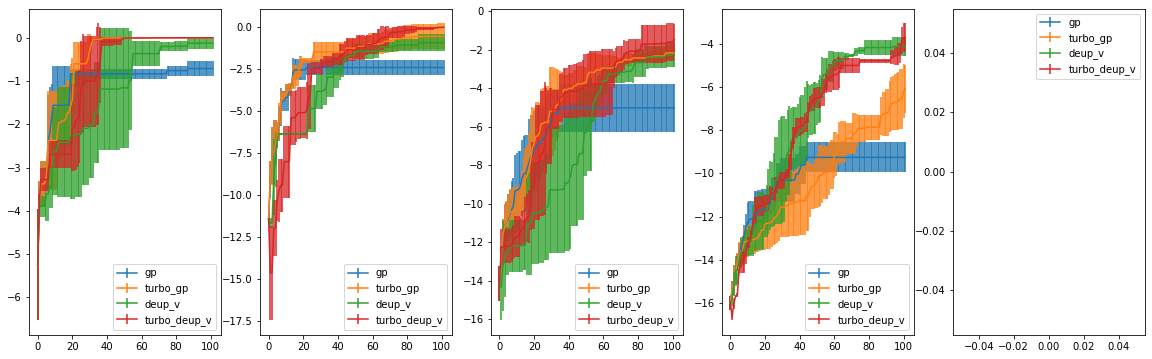

seed 0 , gp current max -16.799823760986328


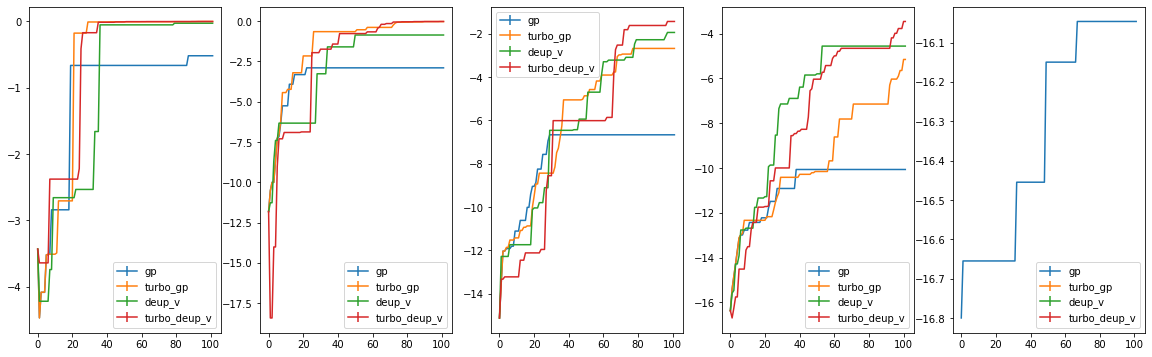

seed 0 , deup-v current max -16.799823760986328


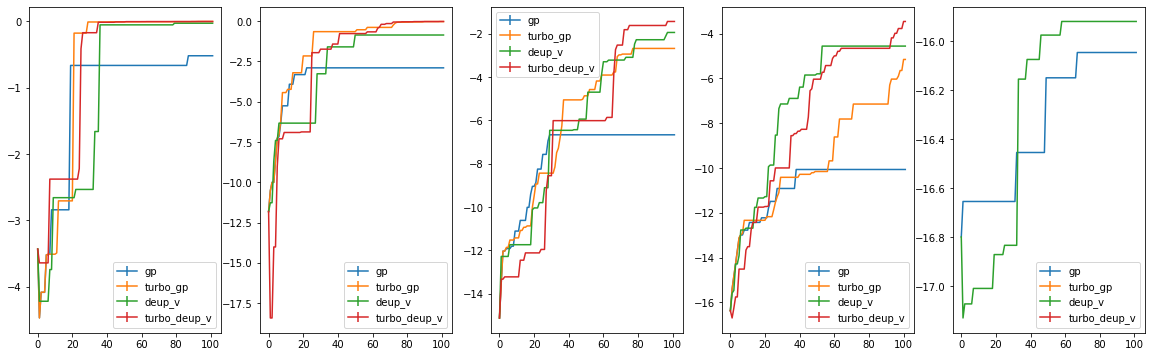

seed 0 , turbo gp current max -16.799823760986328


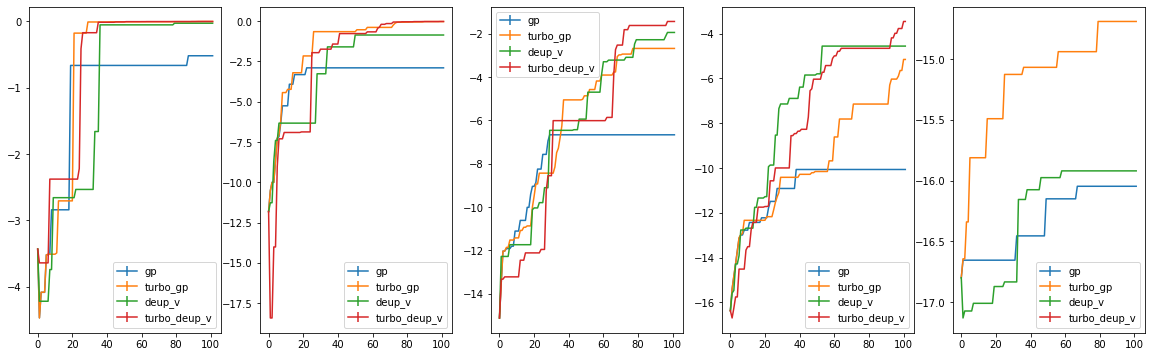

seed 0 , turbo-deup-v current max -16.799823760986328


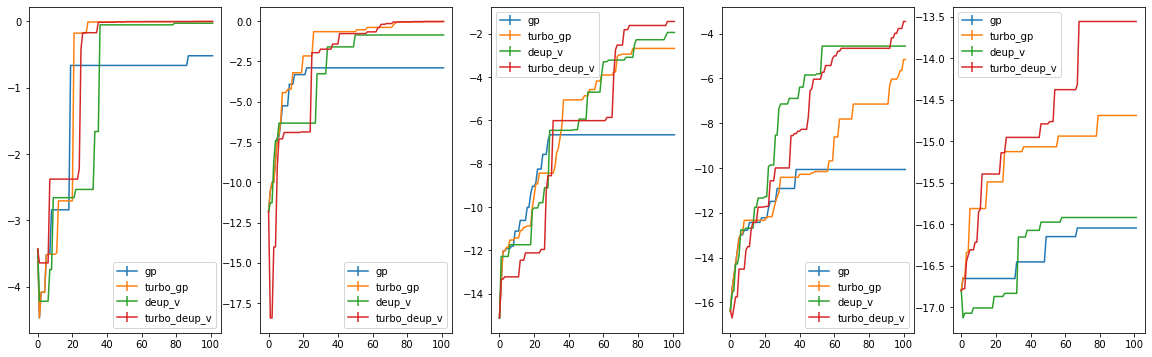

seed 1 , gp current max -16.675220489501953


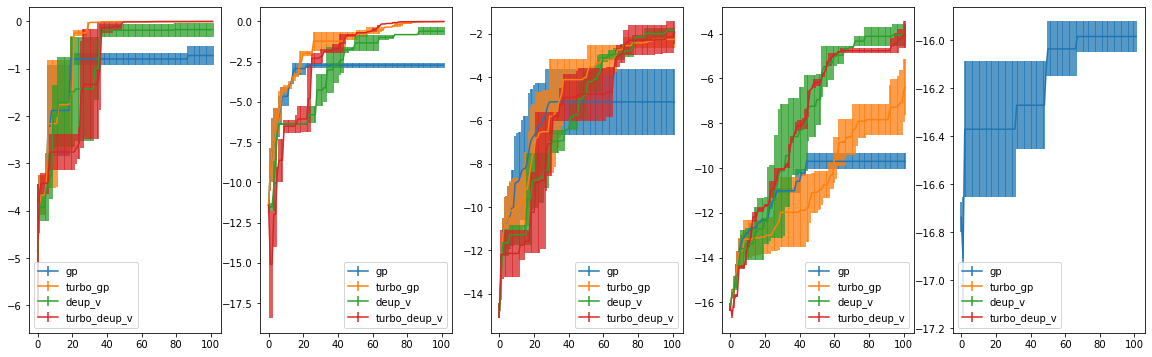

seed 1 , deup-v current max -16.675220489501953


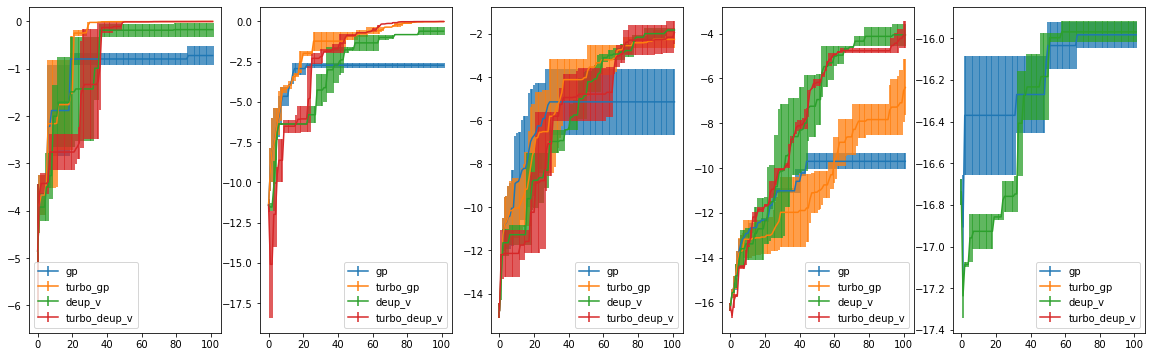

seed 1 , turbo gp current max -16.675220489501953


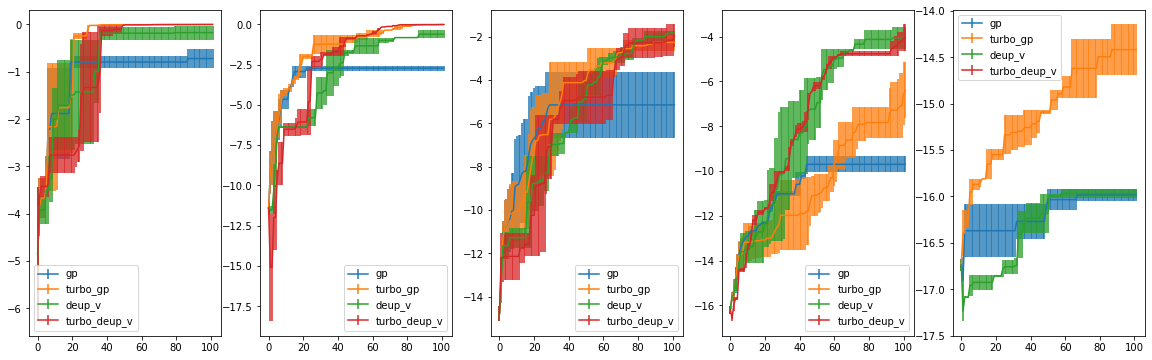

seed 1 , turbo-deup-v current max -16.675220489501953


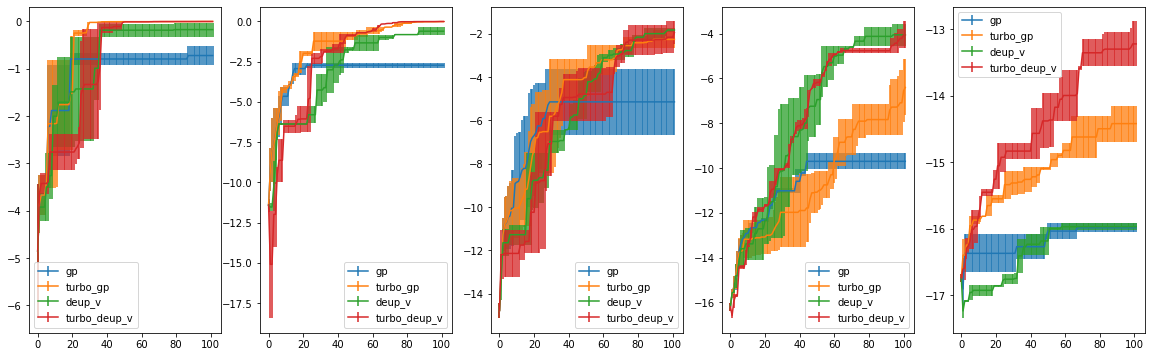

seed 2 , gp current max -17.00235366821289


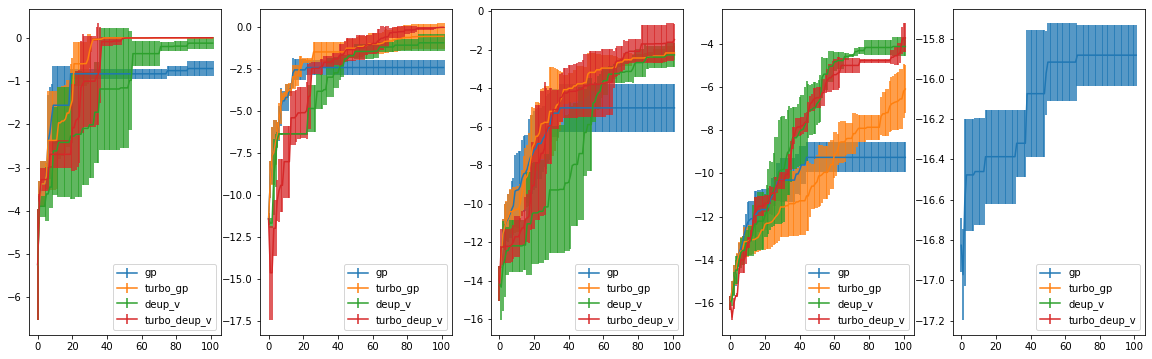

seed 2 , deup-v current max -17.00235366821289


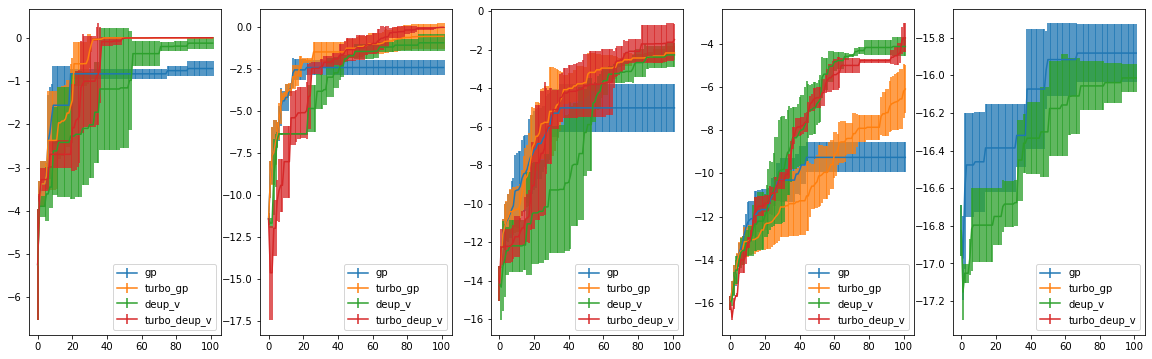

seed 2 , turbo gp current max -17.00235366821289


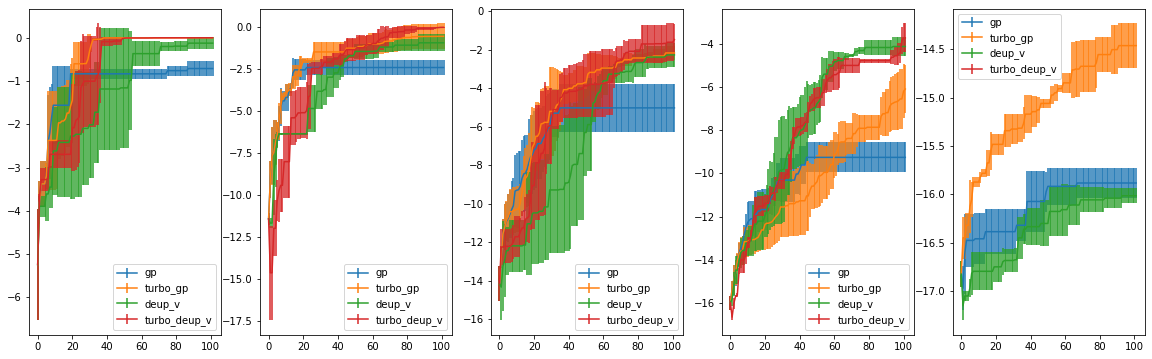

seed 2 , turbo-deup-v current max -17.00235366821289


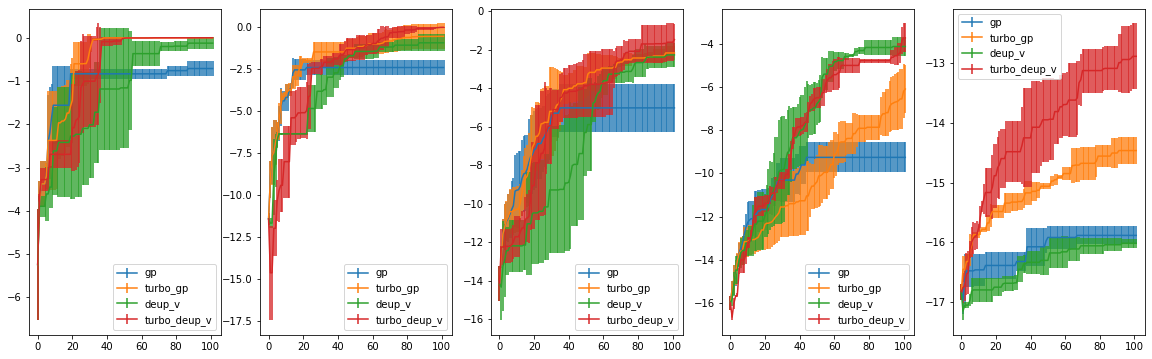

In [33]:
n_seeds = 3
dims = (2, 5, 10, 20, 100)
max_step = 100  # budget
gp_results = {dim: np.zeros((n_seeds, 2 + max_step)) * (-np.float('inf')) for dim in dims}
turbo_gp_results = {dim: np.zeros((n_seeds, 2 + max_step)) * (-np.float('inf')) for dim in dims}
deup_v_results = {dim: np.zeros((n_seeds, 2 + max_step)) * (-np.float('inf')) for dim in dims}
turbo_deup_v_results = {dim: np.zeros((n_seeds, 2 + max_step)) * (-np.float('inf')) for dim in dims}
for dim in dims:
    fun = Ackley(dim=dim, negate=True).to(dtype=dtype, device=device)
    fun.bounds[0, :].fill_(low)
    fun.bounds[1, :].fill_(up)
    dim = fun.dim
    lb, ub = fun.bounds

    X_test = get_initial_points(dim, 1000)

    
    def eval_objective(x):
        """This is a helper function we use to unnormalize and evalaute a point2"""
        return fun(unnormalize(x, fun.bounds))
    for seed in range(n_seeds):
        X_turbo = get_initial_points(dim, n_init)
        Y_turbo = torch.tensor(
            [eval_objective(x) for x in X_turbo], dtype=dtype, device=device
        ).unsqueeze(-1)

        print('seed', seed, ', gp current max', Y_turbo.max().item())
        gp_results[dim][seed, 0] = Y_turbo.max().item()
        state = TurboState(dim, batch_size=batch_size, max_step=max_step)
        best_values, f_losses, e_losses, buffer = train_turbo(X_turbo, Y_turbo, state, deup=False, batch_size=1, turbo=False, dim=dim)
        gp_results[dim][seed, 1:len(best_values) + 1] = best_values
        plot_all(seed, dims)

        print('seed', seed, ', deup-v current max', Y_turbo.max().item())
        deup_v_results[dim][seed, 0] = Y_turbo.max().item()
        state = TurboState(dim, batch_size=batch_size, max_step=max_step)
        best_values, f_losses, e_losses, buffer = train_turbo(X_turbo, Y_turbo, state, deup=True, use_log_unc=True, 
                                                              batch_size=1, features='v', turbo=False, dim=dim)
        deup_v_results[dim][seed, 1:len(best_values) + 1] = best_values
        plot_all(seed, dims)

        print('seed', seed, ', turbo gp current max', Y_turbo.max().item())
        turbo_gp_results[dim][seed, 0] = Y_turbo.max().item()
        state = TurboState(dim, batch_size=batch_size, max_step=max_step)
        best_values, f_losses, e_losses, buffer = train_turbo(X_turbo, Y_turbo, state, deup=False, batch_size=1, turbo=True, dim=dim)
        turbo_gp_results[dim][seed, 1:len(best_values) + 1] = best_values
        plot_all(seed, dims)

        print('seed', seed, ', turbo-deup-v current max', Y_turbo.max().item())
        turbo_deup_v_results[dim][seed, 0] = Y_turbo.max().item()
        state = TurboState(dim, batch_size=batch_size, max_step=max_step)
        best_values, f_losses, e_losses, buffer = train_turbo(X_turbo, Y_turbo, state, deup=True, use_log_unc=True, 
                                                              batch_size=1, features='v', turbo=True, dim=dim)
        turbo_deup_v_results[dim][seed, 1:len(best_values) + 1] = best_values
        plot_all(seed, dims)


In [ ]:
import pickle
pickle.dump({'gp': gp_results, 'deup': deup_v_results, 'turbo_gp': turbo_gp_results, 'turbo_deup': turbo_deup_v_results},
           open('pickles/ackleyloop.pkl', 'wb'))

### you can stop here !

In [ ]:
# REDO experiment with budget of 1000 for dim=100
n_seeds = 3
max_step = 1000  # budget
# gp_results2 = {dim: np.zeros((n_seeds, 2 + max_step)) * (-np.float('inf')) for dim in dims}
# turbo_gp_results2 = {dim: np.zeros((n_seeds, 2 + max_step)) * (-np.float('inf')) for dim in dims}
# deup_v_results2 = {dim: np.zeros((n_seeds, 2 + max_step)) * (-np.float('inf')) for dim in dims}
turbo_deup_v_results2 = {dim: np.zeros((n_seeds, 2 + max_step)) * (-np.float('inf')) for dim in dims}
dim = 100

fun = Ackley(dim=dim, negate=True).to(dtype=dtype, device=device)
fun.bounds[0, :].fill_(low)
fun.bounds[1, :].fill_(up)
dim = fun.dim
lb, ub = fun.bounds

X_test = get_initial_points(dim, 1000)

def eval_objective(x):
    """This is a helper function we use to unnormalize and evalaute a point2"""
    return fun(unnormalize(x, fun.bounds))
for seed in range(n_seeds):
    X_turbo = get_initial_points(dim, n_init)
    Y_turbo = torch.tensor(
        [eval_objective(x) for x in X_turbo], dtype=dtype, device=device
    ).unsqueeze(-1)

#     print('seed', seed, ', gp current max', Y_turbo.max().item())
#     gp_results2[dim][seed, 0] = Y_turbo.max().item()
#     state = TurboState(dim, batch_size=batch_size, max_step=max_step)
#     best_values, f_losses, e_losses, buffer = train_turbo(X_turbo, Y_turbo, state, deup=False, batch_size=1, turbo=False, dim=dim)
#     gp_results2[dim][seed, 1:len(best_values) + 1] = best_values
#     print(gp_results2[dim][:, -1])

#     print('seed', seed, ', deup-v current max', Y_turbo.max().item())
#     deup_v_results2[dim][seed, 0] = Y_turbo.max().item()
#     state = TurboState(dim, batch_size=batch_size, max_step=max_step)
#     best_values, f_losses, e_losses, buffer = train_turbo(X_turbo, Y_turbo, state, deup=True, use_log_unc=True, 
#                                                           batch_size=1, features='v', turbo=False, dim=dim)
#     deup_v_results2[dim][seed, 1:len(best_values) + 1] = best_values
#     print(deup_v_results2[dim][:, -1])

#     print('seed', seed, ', turbo gp current max', Y_turbo.max().item())
#     turbo_gp_results2[dim][seed, 0] = Y_turbo.max().item()
#     state = TurboState(dim, batch_size=batch_size, max_step=max_step)
#     best_values, f_losses, e_losses, buffer = train_turbo(X_turbo, Y_turbo, state, deup=False, batch_size=1, turbo=True, dim=dim)
#     turbo_gp_results2[dim][seed, 1:len(best_values) + 1] = best_values
#     print(turbo_gp_results2[dim][:, -1])

    print('seed', seed, ', turbo-deup-v current max', Y_turbo.max().item())
    turbo_deup_v_results2[dim][seed, 0] = Y_turbo.max().item()
    state = TurboState(dim, batch_size=batch_size, max_step=max_step)
    best_values, f_losses, e_losses, buffer = train_turbo(X_turbo, Y_turbo, state, deup=True, use_log_unc=True, 
                                                          batch_size=1, features='v', turbo=True, dim=dim, print_every=10)
    turbo_deup_v_results2[dim][seed, 1:len(best_values) + 1] = best_values
    print(turbo_deup_v_results2[dim][:, -1])
